In [1092]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV, StratifiedKFold,cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, PolynomialFeatures, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error

#### Importation du CSV et création du dataframe

In [1093]:
df = pd.read_csv("assurance.csv")
df=df.drop_duplicates()

#### Création de la matrice X (variables explicatives) et de la série y (variable cible)

In [1094]:
X = df.drop(['charges','region'], axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, train_size=0.8, random_state=42)
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)


-0.008391982350864469

Suite à l'analyse de données nous avons décidé de supprimer la série "région" étant donné qu'elle n'est pas corrélée à la variable cible 

#### Création d'un pipeline afin d'encoder notre model

In [1095]:
transformer = make_column_transformer((OneHotEncoder(),['sex','smoker']),(RobustScaler(),['age','bmi','children']))

Nous avons besoin d'encoder les variables catégorielles (OneHotEncoder) pour passer des strings à des integer
La standardisation est utilisée pour converger vers la meilleure solution 

#### Entrainement de notre model sur le X_train

In [1136]:
model = make_pipeline(transformer,PolynomialFeatures(2),ElasticNet(l1_ratio=1,random_state=42 ))
model.fit(X_train, y_train)
# y_predict=model.predict(X_train)


/home/apprenant/miniconda3/envs/data_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e+07, tolerance: 1.464e+07
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['sex', 'smoker']),
                                                 ('robustscaler',
                                                  RobustScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('elasticnet', ElasticNet(l1_ratio=1, random_state=42))])

In [1134]:
model.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                    ['sex', 'smoker']),
                                   ('robustscaler', RobustScaler(),
                                    ['age', 'bmi', 'children'])])),
  ('polynomialfeatures', PolynomialFeatures()),
  ('linearregression', LinearRegression())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                  ['sex', 'smoker']),
                                 ('robustscaler', RobustScaler(),
                                  ['age', 'bmi', 'children'])]),
 'polynomialfeatures': PolynomialFeatures(),
 'linearregression': LinearRegression(),
 'columntransformer__n_jobs': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__transformer_weights': None,
 'columntransformer__transformers': [('onehot

In [1098]:
# model.score(X_train,y_train)

In [1099]:
model.score(X_test,y_test)

0.8826927563009515

#### Utilisation d'un RandomizeSearch afin d'avoir un ordre d'idée de l'hyperparamètre d'ElasticNet

In [1137]:
param_search = {'elasticnet__alpha':np.linspace(0,100,1000)}
random_search = RandomizedSearchCV(model, param_distributions=param_search, n_iter=100, cv=5, random_state=42)
random_search.fit(X_train, y_train)
print(random_search.best_params_)

/home/apprenant/miniconda3/envs/data_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.626e+07, tolerance: 1.138e+07
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/data_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+07, tolerance: 1.168e+07
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/data_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

{'elasticnet__alpha': 45.14514514514515}


In [ ]:
model[1].coef_

#### Utilisation d'un GridSearch afin d'obtenir l'hyperparamètre d'ElasticNet( centré autour de la valeur donnée par le RandomizeSearch) le plus efficient

In [1138]:
params = {'elasticnet__alpha':np.linspace(42,50,100), 'elasticnet__l1_ratio':np.linspace(0,1,500),'polynomialfeatures__degree':[1,2]}
grid=GridSearchCV(model, param_grid=params, scoring='r2')
# grid_rmse=GridSearchCV(model, param_grid=params)
grid.fit(X_train, y_train)
# grid_rmse.fit(X_train, y_train)

/home/apprenant/miniconda3/envs/data_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.659e+10, tolerance: 1.138e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/data_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.810e+10, tolerance: 1.168e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted u

Valeur de l'hyperparamètre alpha déterminée grâce au GridSearch

In [1102]:
model.get_params()

{'elasticnet__alpha': 48.06060606060606}

Application du meilleur hyperparamètre (trouvé) à notre model afin d'obtenir le meilleur model

In [1103]:
best_model= grid.best_estimator_
# best_model_rmse= grid_rmse.best_estimator_

#### Présentation des score R2 de notre modèle

In [1104]:
best_model.score(X_train,y_train)

0.828516051275978

In [1105]:
best_model.score(X_test,y_test)

0.8831650915854592

In [1106]:
# best_model_rmse.score(X_train,y_train)

In [1107]:
# best_model_rmse.score(X_test,y_test)

#### Obtention des valeurs cibles que notre modèle prédit

In [1108]:
y_predict=best_model.predict(X_train)
y_predict


array([ 3756.07881405,  4919.98499659, 12553.17986514, ...,
        3787.74752216,  9331.82004264,  7841.19208417])

#### Obtention des valeurs résidues qui sont les écarts entre les valeurs prédites et les valeurs de notre cible

In [1109]:
y_residu=np.abs(y_predict-y_train)


In [1110]:
# 4/(ni-p)

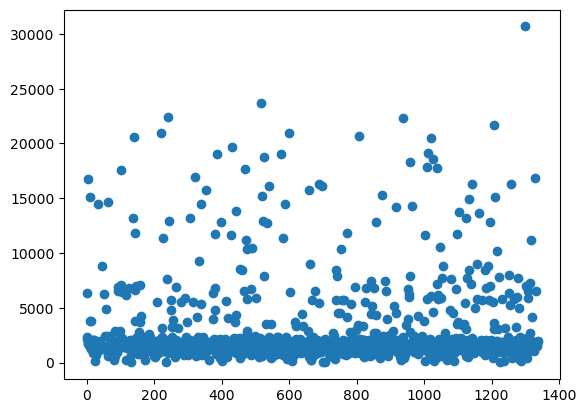

In [1111]:
plt.scatter(X_train.index,y_residu)
plt.show()

#### Affinage du model en supprimant les valeurs aberrantes

Nous avons estimé que les valeurs résidues supérieures à 15000 proviennent de valeurs aberrantes présentent dans notre dataset.
Pour les supprimer nous cherchons d'abord les indices de ces valeurs résiduelles supérieures au seuil déterminé. 

In [1112]:
indice_residu=y_residu[y_residu>20000].index
indice_residu

Int64Index([599, 140, 1300, 242, 1019, 516, 1206, 936, 219, 806], dtype='int64')

Ensuite nous supprimons les valeurs correspondantes dans notre y_residu, X_train et y_train

In [1113]:
y_residu_clean=y_residu.drop(indice_residu)


In [1114]:
X_train_clean=X_train.drop(indice_residu)


In [1115]:
y_train_clean=y_train.drop(indice_residu)

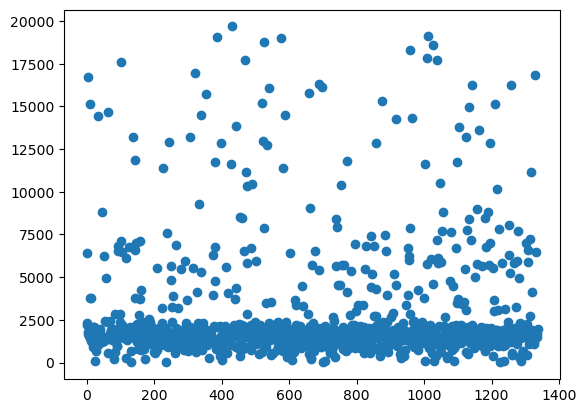

In [1116]:
plt.scatter(X_train_clean.index,y_residu_clean)
plt.show()

In [1117]:
df_clean= df.drop(indice_residu)

In [1118]:
df_clean

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [1119]:
df.loc[indice_residu].smoker.value_counts()

no     9
yes    1
Name: smoker, dtype: int64

In [1120]:
df.smoker.value_counts()

no     1063
yes     274
Name: smoker, dtype: int64

Nous réentrainons notre model avec les nouvelles données

In [1121]:
grid.fit(X_train_clean,y_train_clean)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['sex',
                                                                          'smoker']),
                                                                        ('robustscaler',
                                                                         RobustScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children'])])),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('elasticnet',
                                        ElasticNet(l1_ratio=1,
                                                   random_state=42))]),
             param_grid={'elasticnet__alpha': array([42.        , 42.0...
       47.65656566, 47.73737374, 47.81818182, 47.8989899 , 47.97979798,
       48.06060606, 48.14141414, 48.22222222, 48.3030303 , 48.38383838,
       48.46464646, 48.54545455, 48.62626263, 48.70707071, 48.78787879,
       48.86868687, 48.94949495, 49.03030303, 49.11111111, 49.19191919,
       49.27272727, 49.35353535, 49.43434343, 49.51515152, 49.5959596 ,
       49.67676768, 49.75757576, 49.83838384, 49.91919192, 50.        ])},
             scoring='r2')

In [1122]:
best_model_clean= grid.best_estimator_

In [1123]:
best_model_clean.score(X_train_clean,y_train_clean)

0.8592072646131701

In [1124]:
# best_model_clean.score(X_test,y_test)

In [1125]:
best_model_clean.score(X_test,y_test)

0.8827397620111426

In [1129]:
model_lr = make_pipeline(transformer,PolynomialFeatures(2),LinearRegression())
cross_val=cross_validate(model_lr, X_train, y_train, cv=5)
model_lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['sex', 'smoker']),
                                                 ('robustscaler',
                                                  RobustScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [1130]:
cross_val['test_score'].mean()

0.8214415827911946

In [1131]:
model_lr.score(X_test,y_test)

0.8826792792688223